# Задача 2. Сравнение методов классификации
## Выполнила Милосердова Любовь Михайловна, 471 группа (19.Б11-мм)
## Задача:
- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [x] (**+2 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('heart.csv', index_col=False)

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


### Описание датасета:

- age - age in years
- sex - (1 = male; 0 = female)
- cp - chest pain type
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholestoral in mg/dl
- fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results
- thalach - maximum heart rate achieved
- exang - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0-3) colored by flourosopy
- thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
- target - have disease or not (1=yes, 0=no)


Необходимо решить задачу классификации и научиться предсказывать целовой признак target имеет ли пациент заболевание сердца.

In [4]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## Разведочный анализ данных

In [5]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

Целевой признак примерно одинаково часто принимает 0 и 1, датасет сбалансирован

Рассмотрим распределение значений по каждому признаку

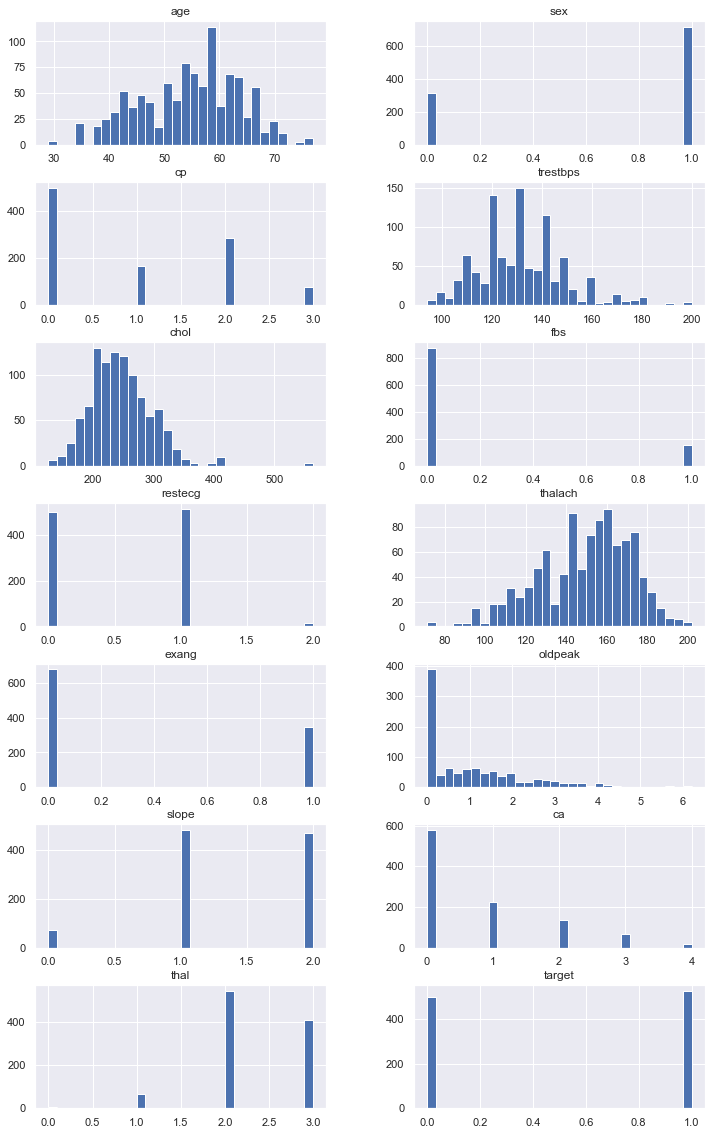

In [6]:
df.hist(bins=30, layout=(7,2), figsize=(12,20), column=df.columns[0:])
plt.show()

По диаграммам можем выделить категориальные признаки.

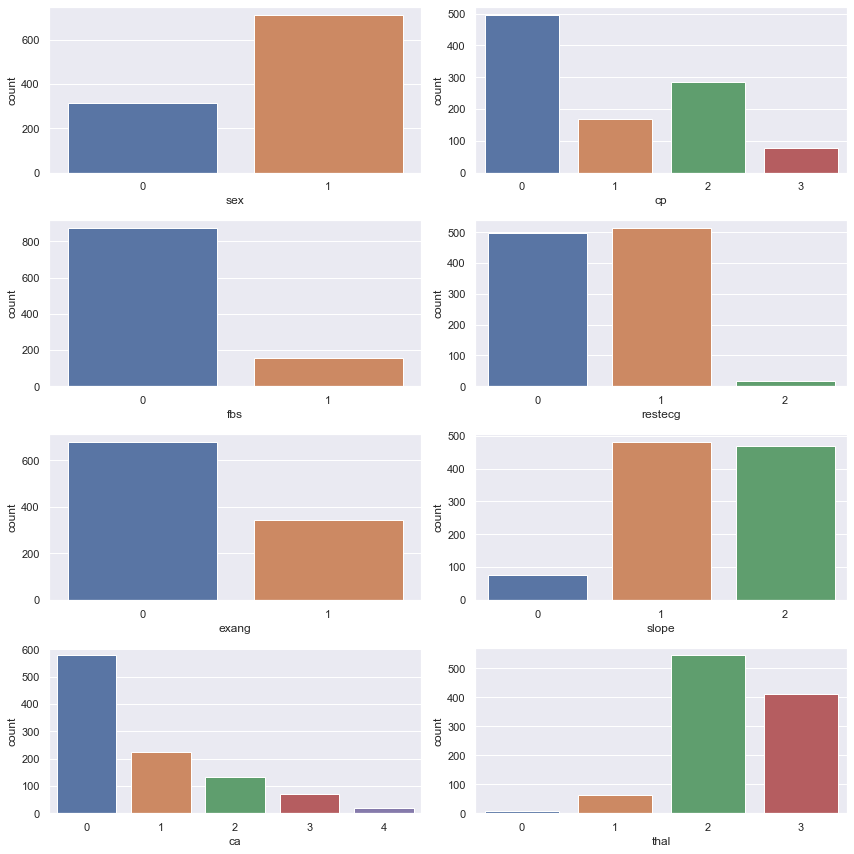

In [7]:
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

plt.figure(figsize=(12,12))
for (index, column) in enumerate(categorical):
    plt.subplot(4, 2, index + 1)
    sns.countplot(data=df[categorical], x=column)
    plt.xlabel(column)
    plt.ylabel("count")

plt.tight_layout(pad = 1.0)
plt.show()

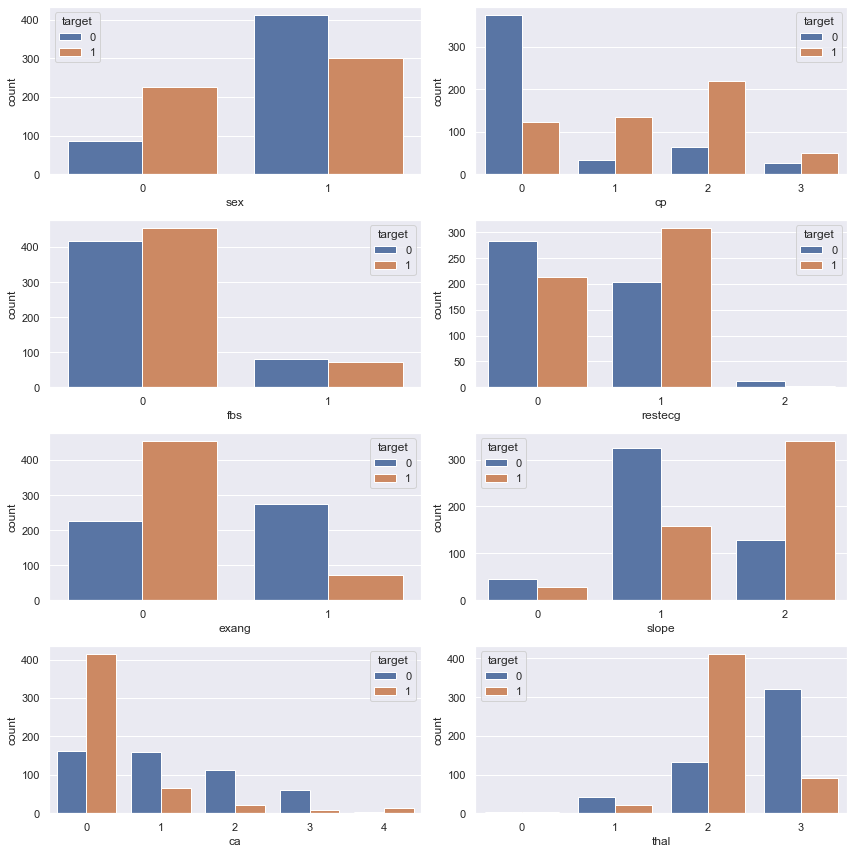

In [8]:
fig = plt.figure(figsize=(12,12))
for (index, column) in enumerate(categorical):
    plt.subplot(4, 2, index + 1)
    sns.countplot(data=df[categorical], x=column, hue=df['target'])
    plt.xlabel(column)
    plt.ylabel("count")

plt.tight_layout(pad = 1.0)
plt.show()

Основные выводы:
- У женщин выше вероятность заболеть, чем у мужчин
- У людей с типами болей в груди 1-3 вероятность заболеть выше, чем у людей с типом 0
- У людей без выявленной стенокардии, вызванная физической нагрузкой, вероятность заболеть выше (кажется, это странно)
- У людей, у которых во время флуороскопии не было обнаружено крупных сосудов, вероятность заболеть выше

In [9]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

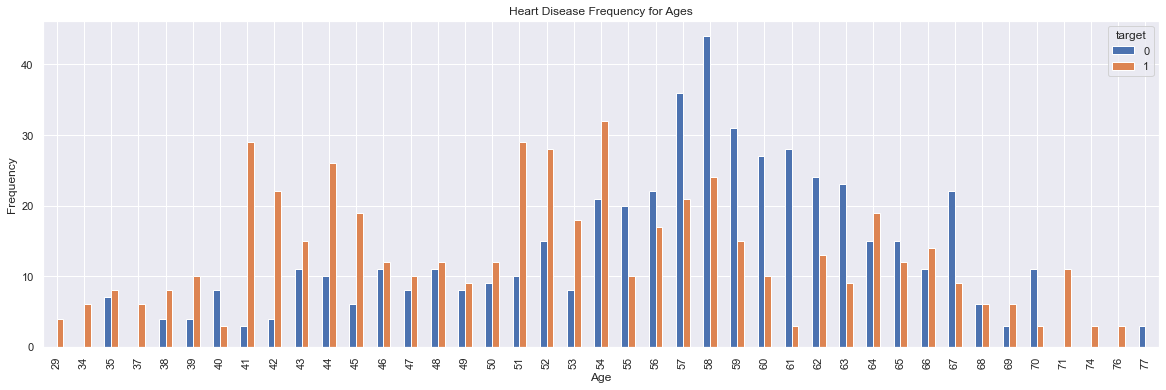

In [10]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Люди болеют чаще в возрасте от 29 до 54 лет. Люди, дожившие до 55 болеют реже, однако после 71 года у них все же могут начаться проблемы с сердцем.

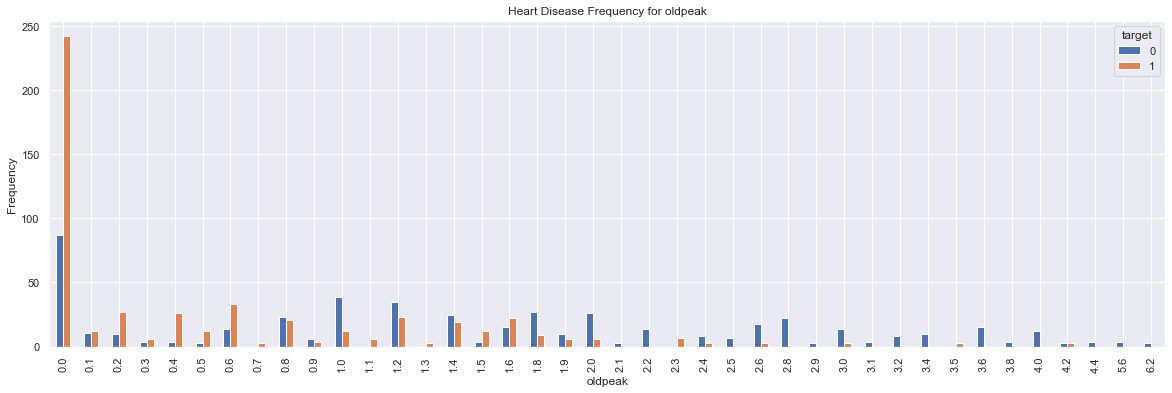

In [11]:
pd.crosstab(df.oldpeak, df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for oldpeak')
plt.xlabel('oldpeak')
plt.ylabel('Frequency')
plt.show()

Люди с показателем st depression от 0 до 0.7 имеют более высокую вероятность болеть

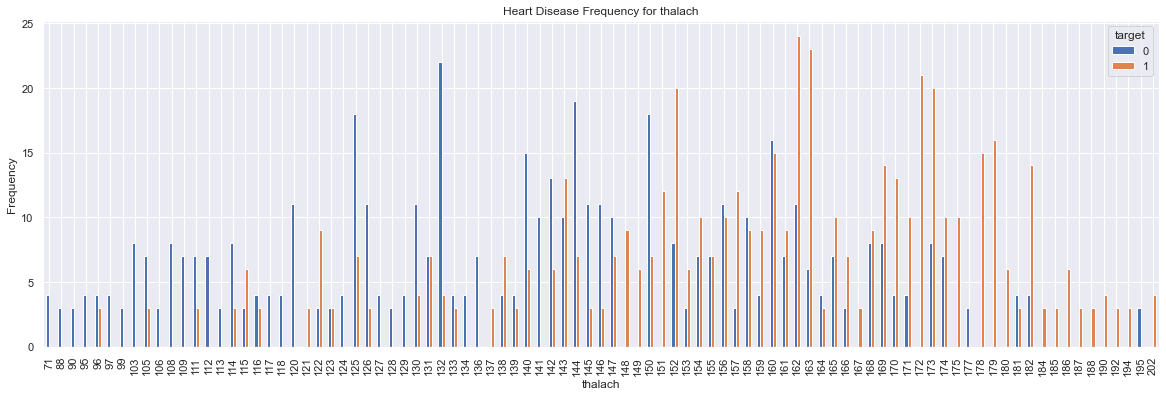

In [12]:
pd.crosstab(df.thalach, df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for thalach')
plt.xlabel('thalach')
plt.ylabel('Frequency')
plt.show()

Чем выше максимальная достигнутая частота сердечных сокращений, тем выше риск заболевания

<AxesSubplot:>

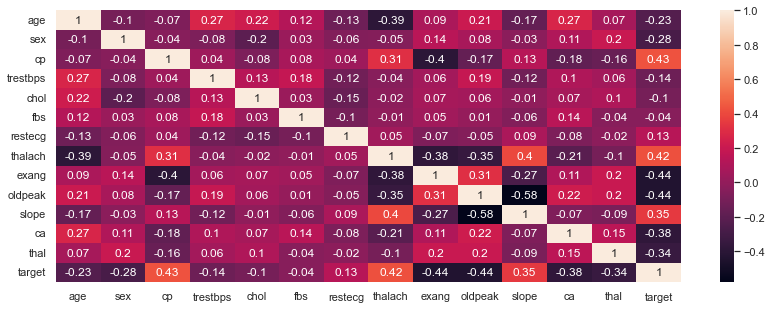

In [13]:
plt.figure(figsize=(14,5))
sns.heatmap(round(df.corr(), 2), annot=True)

Наибольшая (по модулю) корреляция с целевым признаком свойственна признакам: exang, oldpeak, cp, thalach. Наименьшая - chol.

## Преобразование категориальных признаков

In [14]:
frames = [0] * (len(categorical) + 1)
for (i, feature) in enumerate(categorical):
    frames[i] = pd.get_dummies(df[feature], prefix=feature)
frames[len(categorical)] = df
df = pd.concat(frames, axis = 1)
df = df.drop(columns=categorical)
df.head()

,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,fbs_0,fbs_1,restecg_0,restecg_1,...,thal_0,thal_1,thal_2,thal_3,age,trestbps,chol,thalach,oldpeak,target
0,0,1,1,0,0,0,1,0,0,1,...,0,0,0,1,52,125,212,168,1.0,0
1,0,1,1,0,0,0,0,1,1,0,...,0,0,0,1,53,140,203,155,3.1,0
2,0,1,1,0,0,0,1,0,0,1,...,0,0,0,1,70,145,174,125,2.6,0
3,0,1,1,0,0,0,1,0,0,1,...,0,0,0,1,61,148,203,161,0.0,0
4,1,0,1,0,0,0,0,1,0,1,...,0,0,1,0,62,138,294,106,1.9,0


## Разбиение данных и масштабирование

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Реализация методов классификации

In [31]:
def generate_cross_validation_indices(X, y, samples_count=5):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    sample_size = X.shape[0] // samples_count
    batch = [0] * samples_count
    for i in range(samples_count):
        test = np.zeros(X.shape[0], dtype=bool)
        train = np.zeros(X.shape[0], dtype=bool)
        test[indices[i * sample_size:(i + 1) * sample_size]] = True
        train[indices[:i * sample_size]] = True
        train[indices[(i + 1) * sample_size:]] = True

        batch[i] = (X[train], y[train], X[test], y[test])
    return batch

### KNN

In [32]:
from math import sqrt
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial import distance

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, train, k=5, dist=distance.euclidean):
        self.train = train
        self.k = k
        self.dist = dist
    
    def get_neighbors(self, test_row):
        distances = list()
        for (i, train_row) in enumerate(self.train):
            distances.append((train_row, self.dist(test_row[:-1], train_row[:-1])))
        distances.sort(key=lambda tup: tup[1])
        neighbors = list()
        for i in range(self.k):
            neighbors.append(distances[i][0])
        return neighbors
    
    def predict(self, test):
        predictions = list()
        for test_row in test:
            neighbors = self.get_neighbors(test_row)
            output_values = [row[-1] for row in neighbors]
            predictions.append(max(set(output_values), key=output_values.count))
        return(predictions)

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

k_grid = np.arange(3, 11, 2)
distance_grid = [distance.cosine, distance.euclidean, distance.cityblock, distance.chebyshev, distance.hamming]

best_model = KNNClassifier(np.column_stack([X_train_scaled, y_train]))
best_k = 2
best_dist = distance.euclidean
best_score = 0
for k in k_grid:
    for dist in distance_grid:
        model = KNNClassifier(np.column_stack([X_train_scaled, y_train]), k, dist)
        y_pred = model.predict(
            np.column_stack([X_train_scaled, y_train])
        )

        acc = accuracy_score(y_train, y_pred)
        if acc > best_score:
            best_model = model
            best_k = k
            best_dist = dist
            best_score = acc

print("Best k: " + str(best_k))
print("Best dist: " + str(best_dist))

Best k: 3
Best dist: <function cityblock at 0x127c169d0>


In [38]:
accuracies = {}

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    my_knn = KNNClassifier(np.column_stack([cur_x_train, cur_y_train]), best_k, best_dist)
    y_pred = my_knn.predict(
        np.column_stack([cur_x_test, cur_y_test])
    )

    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['My KNN'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Mean Accuracy 0.88671329
Test Mean Precision 0.88714010
Test Mean Recall 0.89975555


## Библиотечные реализации

### Logistic Regression

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': np.arange(1e-05, 5, 0.01)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(X_train_scaled, y_train)

print("Best C: ", gs.best_params_['C'])

Best C:  1.19001


In [41]:
lr = LogisticRegression(C=gs.best_params_['C'])

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    lr.fit(cur_x_train, cur_y_train)
    y_pred = lr.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['Logistic Regression'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Mean Accuracy 0.88671329
Test Mean Precision 0.87354986
Test Mean Recall 0.92166397


### SVM

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

cv = StratifiedKFold(10)

svm = SVC(random_state=11)
grid_svm = GridSearchCV(estimator=svm, cv=cv, param_grid=dict(kernel=kernel, C=C, gamma=gamma))
grid_svm.fit(X_train_scaled, y_train)
print("Best C: ", grid_svm.best_params_['C'])
print("Best gamma: ", grid_svm.best_params_['gamma'])
print("Best kernel: ", grid_svm.best_params_['kernel'])

Best C:  2
Best gamma:  0.1
Best kernel:  rbf


In [42]:
vm = SVC(
    C=grid_svm.best_params_['C'], 
    gamma=grid_svm.best_params_['gamma'], 
    kernel=grid_svm.best_params_['kernel'], 
    random_state = 11
)
acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    svm.fit(cur_x_train, cur_y_train)
    y_pred = svm.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5
    
accuracies['SVM'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Mean Accuracy 0.92307692
Test Mean Precision 0.90911355
Test Mean Recall 0.94678869


### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold


n_neighbors = np.arange(3, 11, 2)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

knn = KNeighborsClassifier()
std_scale = StandardScaler()
n_folds = 5
n_repeats = 5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=12)

knn_clf = GridSearchCV(estimator=knn, cv=rskfold,
                       scoring=scoring, param_grid=dict(n_neighbors=n_neighbors), refit='Accuracy')

knn_clf.fit(X_train_scaled, y_train)

print("Best n_neighbors: ", knn_clf.best_params_['n_neighbors'])

Best n_neighbors:  3


In [46]:
knn = KNeighborsClassifier(n_neighbors=knn_clf.best_params_['n_neighbors'])

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    knn.fit(cur_x_train, cur_y_train)
    y_pred = knn.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['KNN'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Accuracy 0.86993007
Test Precision 0.86525974
Test Recall 0.89092528


### Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

priors = [None, [0.62, 0.38], [0.5, 0.5]]
var_smoothing = np.logspace(0, -9, num=100)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

nb = GaussianNB()
n_folds=5
n_repeats=5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=23)

nb_clf = GridSearchCV(estimator=nb, cv=rskfold,
                      scoring=scoring, return_train_score=True,
                      param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy')

nb_clf.fit(X_train_scaled, y_train)

print("Best params: " + str(nb_clf.best_params_))

Best params: {'priors': [0.62, 0.38], 'var_smoothing': 0.8111308307896871}


In [45]:
nb = GaussianNB(priors=nb_clf.best_params_['priors'], var_smoothing=nb_clf.best_params_['var_smoothing'])

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    nb.fit(cur_x_train, cur_y_train)
    y_pred = nb.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['Naive Bayes'] = acc
print("Test Accuracy {:.8f}".format(acc))
print("Test Precision {:.8f}".format(prec))
print("Test Recall {:.8f}".format(recall))

Test Accuracy 0.86013986
Test Precision 0.84175859
Test Recall 0.90420378


### Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier

criterion = ["gini", "entropy"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

cv = StratifiedKFold(10)

decision_tree = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(estimator=decision_tree, cv=cv,
                       param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features= max_features))
grid_dt.fit(X_train_scaled, y_train)
print("Best params: ", grid_dt.best_params_)

Best params:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


In [48]:
dtc = DecisionTreeClassifier(
    criterion=grid_dt.best_params_['criterion'], 
    max_depth=grid_dt.best_params_['max_depth'], 
    max_features=grid_dt.best_params_['max_features'], 
    min_samples_leaf=grid_dt.best_params_['min_samples_leaf'], 
    min_samples_split=grid_dt.best_params_['min_samples_split'], 
    splitter=grid_dt.best_params_['splitter']
)

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    dtc.fit(cur_x_train, cur_y_train)
    y_pred = dtc.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['Decision Tree'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Mean Accuracy 0.96923077
Test Mean Precision 0.96389154
Test Mean Recall 0.97810246


## Сравнение результатов

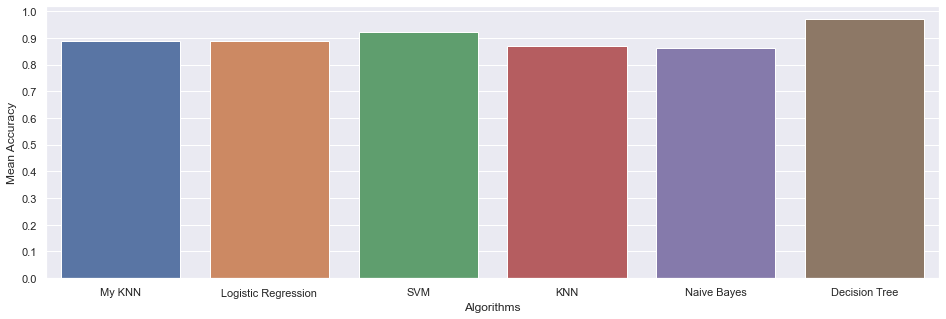

In [51]:
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Mean Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

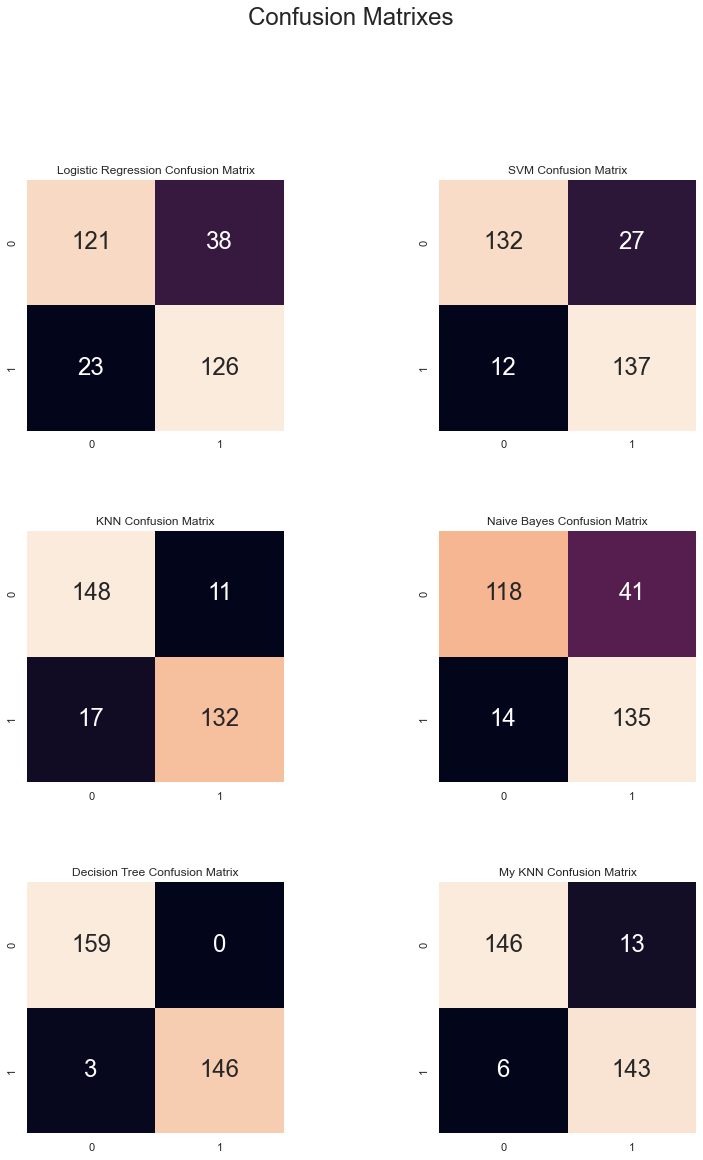

In [50]:
from sklearn.metrics import confusion_matrix

models = [("Logistic Regression", lr), ("SVM", svm), ("KNN", knn), ("Naive Bayes", nb), ("Decision Tree", dtc), ('My KNN', my_knn)]
plt.figure(figsize=(12, 24))
plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)
for (i, model) in enumerate(models):
    plt.subplot(4, 2, i + 1)
    plt.title(model[0] + " Confusion Matrix")
    if model[0] == 'My KNN':
        y_pred = model[1].predict(np.column_stack([X_test_scaled, y_test]))
    else:
        y_pred = model[1].predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, annot_kws={"size": 24})

plt.show()

- Собственная KNN по качеству практически не отличается значительно от библиотечной версии KNN и остальных методов
- Лучше всего себя показал Decision Tree, хуже всего себя показал Naive Bayes

## То же самое на других данных

In [489]:
df = pd.read_csv('winequality-red.csv', index_col=False)

In [490]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [491]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

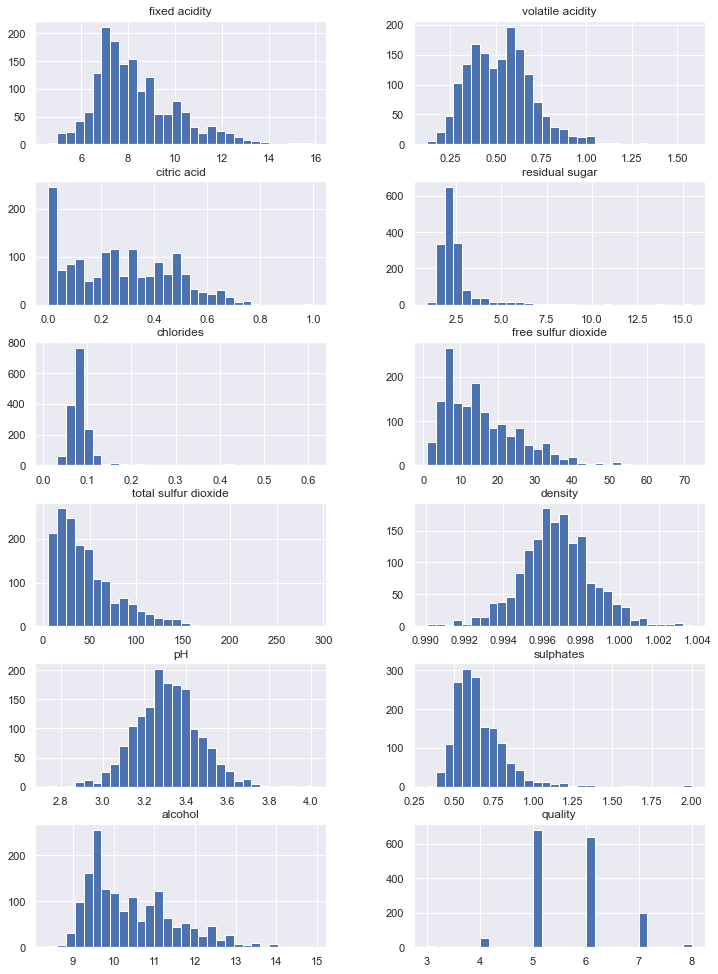

In [492]:
df.hist(bins=30, layout=(7,2), figsize=(12,20), column=df.columns[0:])
plt.show()

In [493]:
df[["fixed acidity","quality"]].groupby(["quality"], as_index = False).mean().sort_values(by = "quality")

,quality,fixed acidity
0,3,8.360000
1,4,7.779245
2,5,8.167254
3,6,8.347179
4,7,8.872362
5,8,8.566667


Без учета самого низкого качества чем выше fixed acidity, тем выше качество вина.

In [494]:
df[["volatile acidity","quality"]].groupby(["quality"], as_index = False).mean().sort_values(by = "quality")

,quality,volatile acidity
0,3,0.884500
1,4,0.693962
2,5,0.577041
3,6,0.497484
4,7,0.403920
5,8,0.423333


Чем ниже volatile acidity, тем выше качество вина.

In [495]:
df[["citric acid","quality"]].groupby(["quality"], as_index = False).mean().sort_values(by = "quality")

,quality,citric acid
0,3,0.171000
1,4,0.174151
2,5,0.243686
3,6,0.273824
4,7,0.375176
5,8,0.391111


Чем выше citric acid, тем выше качество вина.

In [496]:
df[["chlorides","quality"]].groupby(["quality"], as_index = False).mean().sort_values(by = "quality")

,quality,chlorides
0,3,0.122500
1,4,0.090679
2,5,0.092736
3,6,0.084956
4,7,0.076588
5,8,0.068444


Чем ниже chlorides, тем выше качество вина.

In [497]:
df[["sulphates","quality"]].groupby(["quality"], as_index = False).mean().sort_values(by = "quality")

,quality,sulphates
0,3,0.570000
1,4,0.596415
2,5,0.620969
3,6,0.675329
4,7,0.741256
5,8,0.767778


Чем выше sulphates, тем выше качество вина.

In [498]:
df[["alcohol","quality"]].groupby(["quality"], as_index = False).mean().sort_values(by = "quality")

,quality,alcohol
0,3,9.955000
1,4,10.265094
2,5,9.899706
3,6,10.629519
4,7,11.465913
5,8,12.094444


Чем выше alcohol, тем выше качество вина.

<AxesSubplot:>

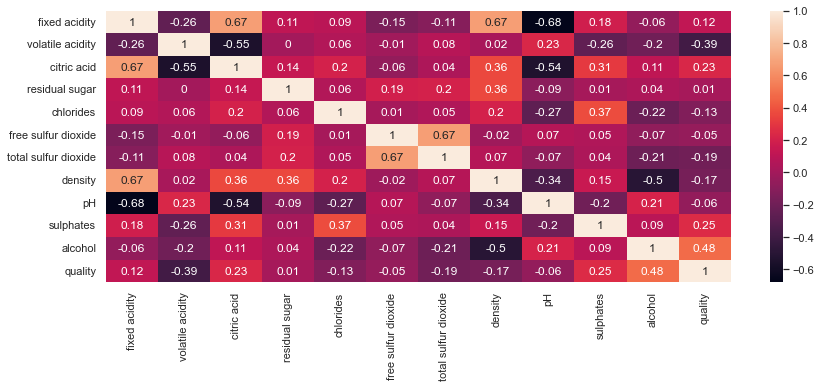

In [499]:
plt.figure(figsize=(14,5))
sns.heatmap(round(df.corr(), 2), annot=True)

Признаки free sulfur dioxide и pH имеют низкую корреляцию с целевым признаком, а также имеют значительную корреляцию с некоторыми другими признаками, поэтому не будем использовать их при построении моделей.

In [500]:
df = df.drop(columns=['free sulfur dioxide', 'pH'])

In [501]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [502]:
df["quality"] =  df["quality"] < 6
df.quality.value_counts()

False    855
True     744
Name: quality, dtype: int64

In [503]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

y = df['quality']
X = df.drop(columns=['quality'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state=42)

Почистим от выбросов

In [504]:
X_train.shape

(1199, 9)

In [508]:
from collections import Counter

def detect_outliers(x, features):
    outlier_indices = []
    
    for c in features:
        Q1 = np.percentile(x[c], 25)
        Q3 = np.percentile(x[c], 75)
        outlier_step = (Q3 - Q1) * 1.5
        outlier_list_col = x[(x[c] < Q1 - outlier_step) | (x[c] > Q3 + outlier_step)].index 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1) 
    return multiple_outliers

train = pd.DataFrame(np.column_stack([X_train, y_train]), columns=df.columns)
outliers = detect_outliers(train, X_train.columns)
train = train.drop(outliers, axis = 0)
X_train = train.drop(columns=["quality"])
y_train = train["quality"]
X_train.shape

(1118, 9)

In [510]:
norm = MinMaxScaler(feature_range = (0, 1))
norm.fit(X_train)
X_train_scaled = norm.transform(X_train)
X_test_scaled = norm.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) 
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns) 

### My KNN

In [534]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

k_grid = np.arange(3, 23, 2)
distance_grid = [distance.minkowski, distance.cosine, distance.euclidean, distance.cityblock, distance.chebyshev, distance.hamming]

best_model = KNNClassifier(np.column_stack([X_train_scaled, y_train]))
best_k = 2
best_dist = distance.euclidean
best_score = 0
for k in k_grid:
    for dist in distance_grid:
        model = KNNClassifier(np.column_stack([X_train_scaled, y_train]), k, dist)
        y_pred = model.predict(
            np.column_stack([X_train_scaled, y_train])
        )

        acc = accuracy_score(y_train, y_pred)
        if acc > best_score:
            best_model = model
            best_k = k
            best_dist = dist
            best_score = acc

print("Best k: " + str(best_k))
print("Best dist: " + str(best_dist))

Best k: 3
Best dist: <function cityblock at 0x127c169d0>


In [535]:
accuracies = {}

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    my_knn = KNNClassifier(np.column_stack([cur_x_train, cur_y_train]), best_k, best_dist)
    y_pred = my_knn.predict(
        np.column_stack([cur_x_test, cur_y_test])
    )

    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['My KNN'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Mean Accuracy 0.72645740
Test Mean Precision 0.70901522
Test Mean Recall 0.70299013


### Logistic Regression

In [538]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': np.arange(1e-05, 5, 0.01)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')

gs.fit(X_train_scaled, y_train)

print("Best C: ", gs.best_params_['C'])

Best C:  0.35001000000000004


In [539]:
lr = LogisticRegression(C=gs.best_params_['C'])

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    lr.fit(cur_x_train, cur_y_train)
    y_pred = lr.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['Logistic Regression'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Mean Accuracy 0.74349776
Test Mean Precision 0.72555367
Test Mean Recall 0.72617082


### SVM

In [540]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

cv = StratifiedKFold(10)

svm = SVC(random_state=11)
grid_svm = GridSearchCV(estimator=svm, cv=cv, param_grid=dict(kernel=kernel, C=C, gamma=gamma))
grid_svm.fit(X_train_scaled, y_train)
print("Best C: ", grid_svm.best_params_['C'])
print("Best gamma: ", grid_svm.best_params_['gamma'])
print("Best kernel: ", grid_svm.best_params_['kernel'])

Best C:  0.25
Best gamma:  scale
Best kernel:  rbf


In [541]:
vm = SVC(
    C=grid_svm.best_params_['C'], 
    gamma=grid_svm.best_params_['gamma'], 
    kernel=grid_svm.best_params_['kernel'], 
    random_state = 11
)
acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    svm.fit(cur_x_train, cur_y_train)
    y_pred = svm.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5
    
accuracies['SVM'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Mean Accuracy 0.74618834
Test Mean Precision 0.71656102
Test Mean Recall 0.75329233


### KNN

In [542]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold


n_neighbors = np.arange(3, 23, 2)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
metric = ['minkowski', 'cosine', 'euclidean', 'cityblock', 'chebyshev', 'hamming']
 

knn = KNeighborsClassifier()
std_scale = StandardScaler()
n_folds = 5
n_repeats = 5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=12)

knn_clf = GridSearchCV(estimator=knn, cv=rskfold,
                       scoring=scoring, param_grid=[{"n_neighbors": n_neighbors , "metric": metric}], refit='Accuracy')

knn_clf.fit(X_train_scaled, y_train)

print("Best n_neighbors: ", knn_clf.best_params_['n_neighbors'])
print("Best metric: ", knn_clf.best_params_['metric'])

Best n_neighbors:  19
Best metric:  cityblock


In [543]:
knn = KNeighborsClassifier(n_neighbors=knn_clf.best_params_['n_neighbors'], metric=knn_clf.best_params_['metric'], weights='distance')

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    knn.fit(cur_x_train, cur_y_train)
    y_pred = knn.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['KNN'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

Test Mean Accuracy 0.76950673
Test Mean Precision 0.74893230
Test Mean Recall 0.76126003


### Naive Bayes

In [544]:
from sklearn.naive_bayes import GaussianNB

priors = [None, [0.62, 0.38], [0.5, 0.5]]
var_smoothing = np.logspace(0, -9, num=100)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

nb = GaussianNB()
n_folds=5
n_repeats=5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=23)

nb_clf = GridSearchCV(estimator=nb, cv=rskfold,
                      scoring=scoring, return_train_score=True,
                      param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy')

nb_clf.fit(X_train_scaled, y_train)

print("Best params: " + str(nb_clf.best_params_))

Best params: {'priors': [0.62, 0.38], 'var_smoothing': 0.1873817422860384}


In [545]:
nb = GaussianNB(priors=nb_clf.best_params_['priors'], var_smoothing=nb_clf.best_params_['var_smoothing'])

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    nb.fit(cur_x_train, cur_y_train)
    y_pred = nb.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['Naive Bayes'] = acc
print("Test Accuracy {:.8f}".format(acc))
print("Test Precision {:.8f}".format(prec))
print("Test Recall {:.8f}".format(recall))

Test Accuracy 0.73811659
Test Precision 0.73009498
Test Recall 0.69365199


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

criterion = ["gini", "entropy"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

cv = StratifiedKFold(10)

decision_tree = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(estimator=decision_tree, cv=cv,
                       param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features= max_features))
grid_dt.fit(X_train_scaled, y_train)
print("Best params: ", grid_dt.best_params_)

In [ ]:
dtc = DecisionTreeClassifier(
    criterion=grid_dt.best_params_['criterion'], 
    max_depth=grid_dt.best_params_['max_depth'], 
    max_features=grid_dt.best_params_['max_features'], 
    min_samples_leaf=grid_dt.best_params_['min_samples_leaf'], 
    min_samples_split=grid_dt.best_params_['min_samples_split'], 
    splitter=grid_dt.best_params_['splitter']
)

acc, prec, recall = 0, 0, 0
for (cur_x_train, cur_y_train, cur_x_test, cur_y_test) in generate_cross_validation_indices(X_train_scaled, y_train):
    dtc.fit(cur_x_train, cur_y_train)
    y_pred = dtc.predict(cur_x_test)
    
    acc += accuracy_score(cur_y_test, y_pred) / 5
    prec += precision_score(cur_y_test, y_pred) / 5
    recall += recall_score(cur_y_test, y_pred) / 5

accuracies['Decision Tree'] = acc
print("Test Mean Accuracy {:.8f}".format(acc))
print("Test Mean Precision {:.8f}".format(prec))
print("Test Mean Recall {:.8f}".format(recall))

## Сравнение результатов

In [ ]:
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Mean Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

models = [("Logistic Regression", lr), ("SVM", svm), ("KNN", knn), ("Naive Bayes", nb), ("Decision Tree", dtc), ('My KNN', my_knn)]
plt.figure(figsize=(12, 24))
plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)
for (i, model) in enumerate(models):
    plt.subplot(4, 2, i + 1)
    plt.title(model[0] + " Confusion Matrix")
    if model[0] == 'My KNN':
        y_pred = model[1].predict(np.column_stack([X_test_scaled, y_test]))
    else:
        y_pred = model[1].predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, annot_kws={"size": 24})

plt.show()

- Получилось достичь средних результатов (не плохо, но и не отлично), возможно это вызвано тем, что некоторые признаки лучше коррелируют скорее с уровнями качества (3-8), чем с разделением на плохие и хорошие вина
- Лучше всего себя показал библиотечный KNN
- Реализованный KNN по качеству не хуже рассмотренных библиотечных реализаций